In [ ]:
!pip install yahoo_fin
!pip install tabulate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 10.8 MB/s eta 0:00:00
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6048 sha256=b1ff442cf00951161139db3bdd2898ecadf6a8f3005e2c2ca7103480f8dcb3ef
  Stored in directory: /root/.cache/pip/wheels/f0/69/93/a47e9d621be168e9e33c7ce60524393c0b92ae83cf6c6e89c5
Successfully built sgmllib3k
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.7
    Uninstalling urllib3-2.0.7:
      Successfully uninstalled urllib3-2.0.7


In [ ]:
import numpy as np
import time as tm
import datetime as dt
import tensorflow as tf
import pandas as pd
from tabulate import tabulate
from yahoo_fin import stock_info as yf
from sklearn.preprocessing import MinMaxScaler
from collections import deque
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, BatchNormalization, Bidirectional
import matplotlib.pyplot as plt

In [ ]:
N_STEPS = 7
LOOKUP_STEPS = [1, 2, 3]
STOCK = 'BBCA.JK'
date_now = tm.strftime('%Y-%m-%d')
date_3_years_back = (dt.date.today() - dt.timedelta(days=1104)).strftime('%Y-%m-%d')

In [ ]:
init_df = yf.get_data(
    STOCK,
    start_date=date_3_years_back,
    end_date=date_now,
    interval='1d')

In [ ]:
init_df = init_df.drop(['open', 'high', 'low', 'adjclose', 'ticker', 'volume'], axis=1)
init_df['date'] = init_df.index

In [ ]:
init_df

,close,date
2021-03-02,7015.0,2021-03-02
2021-03-03,7000.0,2021-03-03
2021-03-04,6720.0,2021-03-04
2021-03-05,6800.0,2021-03-05
2021-03-08,6720.0,2021-03-08
...,...,...
2024-03-04,9750.0,2024-03-04
2024-03-05,9800.0,2024-03-05
2024-03-06,9950.0,2024-03-06
2024-03-07,10125.0,2024-03-07


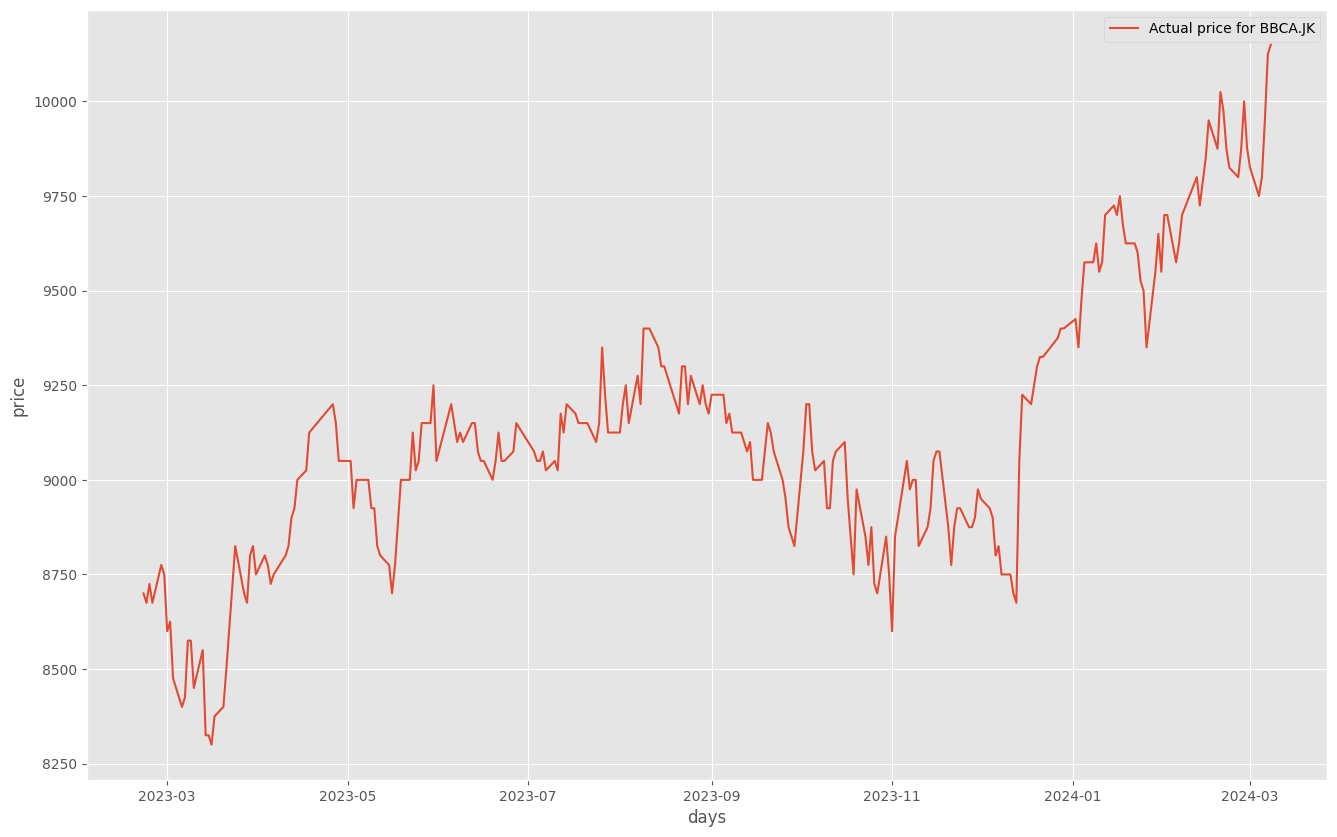

In [ ]:
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(init_df['close'][-250:])
plt.xlabel("days")
plt.ylabel("price")
plt.legend([f'Actual price for {STOCK}'])
plt.show()

In [ ]:
scaler = MinMaxScaler()
init_df['close'] = scaler.fit_transform(np.expand_dims(init_df['close'].values, axis=1))

In [ ]:
def PrepareData(days):
  df = init_df.copy()
  df['future'] = df['close'].shift(-days)
  last_sequence = np.array(df[['close']].tail(days))
  df.dropna(inplace=True)
  sequence_data = []
  sequences = deque(maxlen=N_STEPS)
  for entry, target in zip(df[['close'] + ['date']].values, df['future'].values):
      sequences.append(entry)
      if len(sequences) == N_STEPS:
          sequence_data.append([np.array(sequences), target])
  last_sequence = list([s[:len(['close'])] for s in sequences]) + list(last_sequence)
  last_sequence = np.array(last_sequence).astype(np.float32)
  X, Y = [], []
  for seq, target in sequence_data:
      X.append(seq)
      Y.append(target)
  X = np.array(X)
  Y = np.array(Y)
  return df, last_sequence, X, Y

# sampe sini

In [ ]:
def GetTrainedModel(x_train, y_train):
  model = Sequential()
  model.add(Bidirectional(LSTM(16, return_sequences=True, input_shape=(N_STEPS, len(['close'])))))
  model.add(Bidirectional(LSTM(16, return_sequences=True)))
  model.add(Dropout(0.2))
  model.add(Bidirectional(LSTM(10, return_sequences=True)))
  model.add(Bidirectional(LSTM(10, return_sequences=True)))
  model.add(Dense(64))
  model.add(Bidirectional(LSTM(8, return_sequences=True)))
  model.add(Bidirectional(LSTM(8, return_sequences=True)))
  model.add(Dropout(0.2))
  model.add(Bidirectional(LSTM(4, return_sequences=True)))
  model.add(Bidirectional(LSTM(4, return_sequences=True)))
  model.add(Dense(32))
  model.add(tf.keras.layers.GlobalAveragePooling1D())
  model.add(Dense(64))
  model.add(Dropout(0.1))
  model.add(Dense(8))
  model.add(Dense(1))
  BATCH_SIZE = 64
  EPOCHS = 50
  model.compile(loss='mse', optimizer='adam')
  model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1)
  model.summary()
  return model

In [ ]:
predictions = []
for step in LOOKUP_STEPS:
  df, last_sequence, x_train, y_train = PrepareData(step)
  x_train = x_train[:, :, :len(['close'])].astype(np.float32)
  model = GetTrainedModel(x_train, y_train)
  model.save(f'BBCA.JK{step}.h5')
  last_sequence = last_sequence[-N_STEPS:]
  last_sequence = np.expand_dims(last_sequence, axis=0)
  prediction = model.predict(last_sequence)
  predicted_price = scaler.inverse_transform(prediction)[0][0]
  predictions.append(round(float(predicted_price), 2))

Epoch 1/50
12/12 [==============================] - 62s 46ms/step - loss: 0.1611
Epoch 2/50
12/12 [==============================] - 1s 43ms/step - loss: 0.0683
Epoch 3/50
12/12 [==============================] - 1s 45ms/step - loss: 0.0548
Epoch 4/50
12/12 [==============================] - 1s 43ms/step - loss: 0.0293
Epoch 5/50
12/12 [==============================] - 1s 44ms/step - loss: 0.0075
Epoch 6/50
12/12 [==============================] - 1s 42ms/step - loss: 0.0055
Epoch 7/50
12/12 [==============================] - 1s 45ms/step - loss: 0.0046
Epoch 8/50
12/12 [==============================] - 1s 42ms/step - loss: 0.0041
Epoch 9/50
12/12 [==============================] - 1s 45ms/step - loss: 0.0037
Epoch 10/50
12/12 [==============================] - 0s 41ms/step - loss: 0.0040
Epoch 11/50
12/12 [==============================] - 1s 42ms/step - loss: 0.0037
Epoch 12/50
12/12 [==============================] - 1s 44ms/step - loss: 0.0038
Epoch 13/50
12/12 [=================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 7s 7s/step
Epoch 1/50
12/12 [==============================] - 40s 44ms/step - loss: 0.1784
Epoch 2/50
12/12 [==============================] - 1s 45ms/step - loss: 0.0696
Epoch 3/50
12/12 [==============================] - 1s 43ms/step - loss: 0.0588
Epoch 4/50
12/12 [==============================] - 1s 44ms/step - loss: 0.0390
Epoch 5/50
12/12 [==============================] - 1s 44ms/step - loss: 0.0122
Epoch 6/50
12/12 [==============================] - 1s 44ms/step - loss: 0.0077
Epoch 7/50
12/12 [==============================] - 1s 43ms/step - loss: 0.0067
Epoch 8/50
12/12 [==============================] - 1s 44ms/step - loss: 0.0051
Epoch 9/50
12/12 [==============================] - 1s 43ms/step - loss: 0.0050
Epoch 10/50
12/12 [==============================] - 1s 43ms/step - loss: 0.0048
Epoch 11/50
12/12 [==============================] - 1s 44ms/step - loss: 0.0042
Epoch 12/50
12/12 [==============================] - 1s 71ms/step -

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 6s 6s/step
Epoch 1/50
12/12 [==============================] - 38s 71ms/step - loss: 0.1672
Epoch 2/50
12/12 [==============================] - 1s 81ms/step - loss: 0.0673
Epoch 3/50
12/12 [==============================] - 1s 83ms/step - loss: 0.0548
Epoch 4/50
12/12 [==============================] - 1s 45ms/step - loss: 0.0294
Epoch 5/50
12/12 [==============================] - 1s 44ms/step - loss: 0.0073
Epoch 6/50
12/12 [==============================] - 1s 46ms/step - loss: 0.0065
Epoch 7/50
12/12 [==============================] - 1s 43ms/step - loss: 0.0056
Epoch 8/50
12/12 [==============================] - 1s 44ms/step - loss: 0.0056
Epoch 9/50
12/12 [==============================] - 1s 44ms/step - loss: 0.0049
Epoch 10/50
12/12 [==============================] - 1s 45ms/step - loss: 0.0045
Epoch 11/50
12/12 [==============================] - 1s 46ms/step - loss: 0.0045
Epoch 12/50
12/12 [==============================] - 1s 47ms/step -

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 9s 9s/step


In [ ]:
copy_df = init_df.copy()
y_predicted = model.predict(x_train)
y_predicted_transformed = np.squeeze(scaler.inverse_transform(y_predicted))
first_seq = scaler.inverse_transform(np.expand_dims(y_train[:6], axis=1))
last_seq = scaler.inverse_transform(np.expand_dims(y_train[-3:], axis=1))
y_predicted_transformed = np.append(first_seq, y_predicted_transformed)
y_predicted_transformed = np.append(y_predicted_transformed, last_seq)
copy_df[f'predicted_close'] = y_predicted_transformed

date_now = dt.date.today()
date_tomorrow = date_now + dt.timedelta(days=1)
date_after_tomorrow = date_now + dt.timedelta(days=2)

new_data = [
    ['nan', f'{date_now}', predictions[0], 'nan'],
    ['nan', f'{date_tomorrow}', predictions[1], 'nan'],
    ['nan', f'{date_after_tomorrow}', predictions[2], 'nan'],
]

new_df = pd.DataFrame(new_data, columns=['close', 'date', 'predicted_close', 'no'])
result_df = pd.concat([copy_df, new_df], ignore_index=True)
print(tabulate(result_df, headers='keys', tablefmt='pretty', showindex=False))

23/23 [==============================] - 0s 19ms/step
+-----------------------+---------------------+------------------+-----+
|         close         |        date         | predicted_close  | no  |
+-----------------------+---------------------+------------------+-----+
|  0.2517899761336515   | 2021-03-02 00:00:00 |      6625.0      | nan |
|  0.2482100238663485   | 2021-03-03 00:00:00 |      6610.0      | nan |
|  0.18138424821002386  | 2021-03-04 00:00:00 |      6705.0      | nan |
|  0.2004773269689737   | 2021-03-05 00:00:00 |      6760.0      | nan |
|  0.18138424821002386  | 2021-03-08 00:00:00 |      6620.0      | nan |
|  0.15393794749403344  | 2021-03-09 00:00:00 |      6565.0      | nan |
|  0.17780429594272085  | 2021-03-10 00:00:00 | 6665.65478515625 | nan |
|  0.1921241050119331   | 2021-03-12 00:00:00 | 6648.4248046875  | nan |
|  0.16825775656324593  | 2021-03-15 00:00:00 | 6622.4091796875  | nan |
|  0.15871121718377101  | 2021-03-16 00:00:00 | 6605.19873046875 | nan

23/23 [==============================] - 0s 11ms/step


<ipython-input-13-da803110d01a>:15: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  copy_df.loc[date_tomorrow] = [0, date_tomorrow, 0, predictions[1]]
<ipython-input-13-da803110d01a>:16: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  copy_df.loc[date_after_tomorrow] = [0, date_after_tomorrow, 0, predictions[2]]


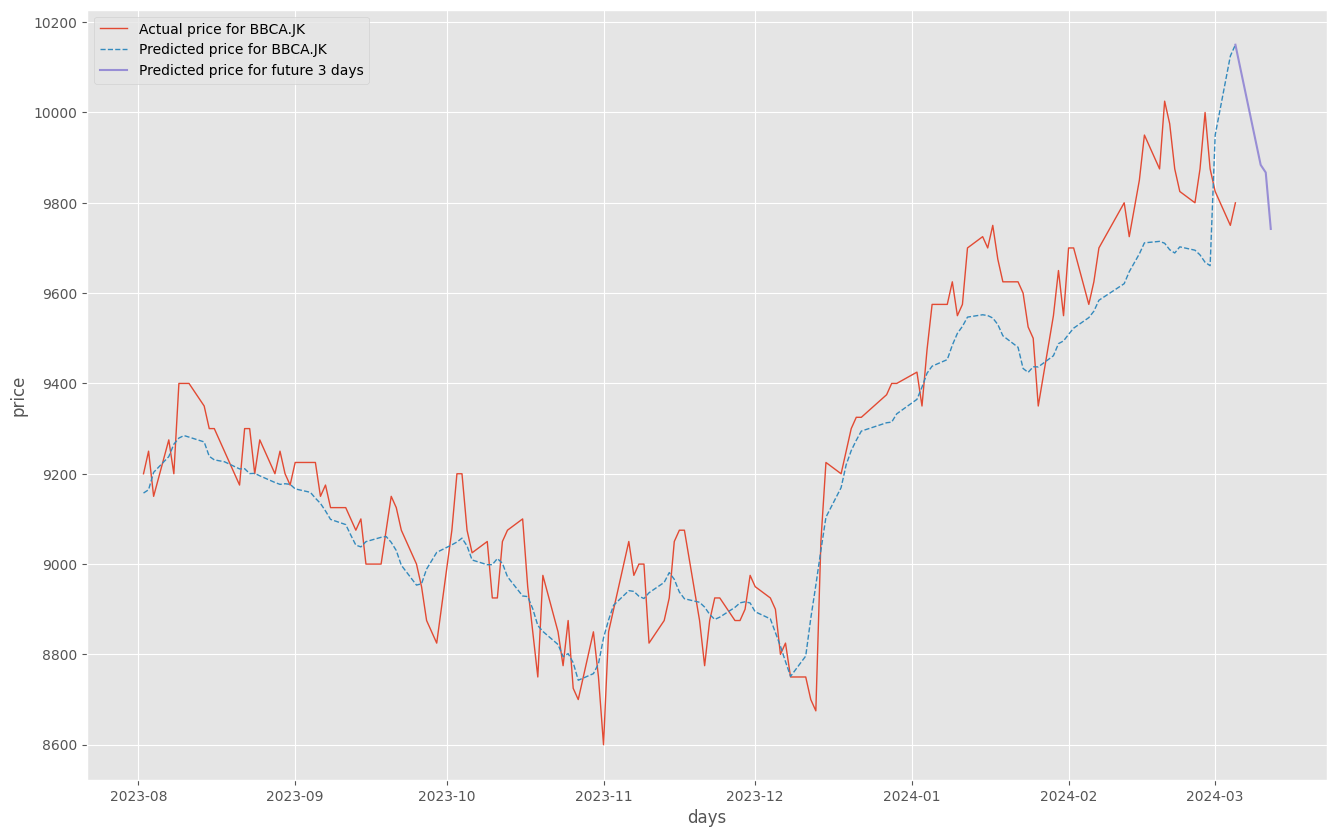

In [ ]:
copy_df = df.copy()
y_predicted = model.predict(x_train)
y_predicted_transformed = np.squeeze(scaler.inverse_transform(y_predicted))
first_seq = scaler.inverse_transform(np.expand_dims(y_train[:3], axis=1))
last_seq = scaler.inverse_transform(np.expand_dims(y_train[-3:], axis=1))
y_predicted_transformed = np.append(first_seq, y_predicted_transformed)
y_predicted_transformed = np.append(y_predicted_transformed, last_seq)
copy_df[f'predicted_close'] = y_predicted_transformed

date_now = dt.date.today()
date_tomorrow = dt.date.today() + dt.timedelta(days=1)
date_after_tomorrow = dt.date.today() + dt.timedelta(days=2)

copy_df.loc[date_now] = [0, date_now, 0, predictions[0]]
copy_df.loc[date_tomorrow] = [0, date_tomorrow, 0, predictions[1]]
copy_df.loc[date_after_tomorrow] = [0, date_after_tomorrow, 0, predictions[2]]

plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
copy_df['close'] = scaler.inverse_transform(np.expand_dims(copy_df['close'], axis=1))
plt.plot(copy_df['close'][-150:].head(147),linewidth=1)
plt.plot(copy_df['predicted_close'][-150:].head(147), linewidth=1, linestyle='dashed')
plt.plot(copy_df['predicted_close'][-150:].tail(4))
plt.xlabel('days')
plt.ylabel('price')
plt.legend([f'Actual price for {STOCK}',
            f'Predicted price for {STOCK}',
            f'Predicted price for future 3 days'])
plt.show()